In [ ]:
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
from dataclasses import dataclass, field
import ace_tools as tools

# --- 1) Data classes ---

@dataclass
class Physiology:
    weight_kg: float = 70.0
    V_blood: float = 5.0
    V_liver: float = 1.8
    Q_liver: float = 90.0
    V_muscle: float = 29.0
    Q_muscle: float = 450.0
    V_fat: float = 18.0
    Q_fat: float = 30.0
    CLint_liver: float = 20.0

@dataclass
class Compound:
    name: str
    Kp_liver: float = 10.0
    Kp_muscle: float = 3.0
    Kp_fat: float = 50.0
    k_abs: float = 1.0  # gut absorption rate (1/h)

@dataclass
class DosingEvent:
    type: str      # 'iv_bolus', 'iv_infusion', 'oral'
    amount: float  # mg
    time: float    # h
    duration: float = 0.0  # infusion duration in h

# --- 2) Simulator class ---

class PBPKQSPSimulator:
    def __init__(self, phys: Physiology, cmpd: Compound, qsp_params=None):
        self.phys = phys
        self.cmpd = cmpd
        self.qsp = qsp_params  # tuple(kon, koff, Rtot, kprod, kdeg) or None
        # compartment definitions: Gut, Blood, Liver, Muscle, Fat
        self.names = ['Gut','Blood','Liver','Muscle','Fat']
        self.vols = [1.0, phys.V_blood, phys.V_liver, phys.V_muscle, phys.V_fat]
        self.flows = [0.0, 0.0, phys.Q_liver, phys.Q_muscle, phys.Q_fat]
        self.kps   = [1.0, 1.0, cmpd.Kp_liver, cmpd.Kp_muscle, cmpd.Kp_fat]
        self.clint = [0.0, 0.0, phys.CLint_liver, 0.0, 0.0]
        self.n_pk = len(self.names)
        self.n_qsp = 3 if qsp_params else 0

    def odes(self, t, y, events):
        # 1) dosing injections (mg/h)
        inj = np.zeros(self.n_pk)
        for ev in events:
            if ev.type=='iv_bolus' and abs(t-ev.time)<self.dt/2:
                inj[1] += ev.amount/self.dt
            elif ev.type=='iv_infusion' and ev.time <= t < ev.time+ev.duration:
                inj[1] += ev.amount/ev.duration
            elif ev.type=='oral' and abs(t-ev.time)<self.dt/2:
                inj[0] += ev.amount/self.dt

        # 2) PBPK states and derivatives
        Agut, Ab, Aliv, Amusc, Afat = y[:5]
        # gut absorption
        dAgut = -self.cmpd.k_abs*Agut + inj[0]
        # concentration in blood
        Cb = Ab/self.vols[1]
        # distribution and clearance
        dAb = self.cmpd.k_abs*Agut + inj[1]
        dAliv = 0.0; dAmusc = 0.0; dAfat = 0.0
        for idx, (vol, flow, kp, cl) in enumerate(zip(self.vols, self.flows, self.kps, self.clint)):
            if idx<2: continue  # skip Gut(0) and Blood(1) in loop
            Ci = y[idx]/vol
            flux = flow*(Cb - Ci/kp)
            # mass balances
            dAb   -= flux
            if idx==2: dAliv = flux - cl*Ci
            elif idx==3: dAmusc = flux
            elif idx==4: dAfat  = flux

        dPK = [dAgut, dAb, dAliv, dAmusc, dAfat]

        # 3) QSP if provided
        if self.qsp:
            kon, koff, Rtot, kprod, kdeg = self.qsp
            Rf, Rc, M = y[5:8]
            bind = kon*Cb*Rf - koff*Rc
            dRf = -bind
            dRc = bind
            dM  = kprod*Rc - kdeg*M
            return dPK + [dRf, dRc, dM]

        return dPK

    def simulate(self, events, t_end=24.0, dt=0.1):
        # initial state vector
        y0 = [0.0]*self.n_pk
        # add QSP initial states
        if self.qsp:
            y0 += [self.qsp[2], 0.0, 0.0]  # Rf, Rc, M
        # simulation
        self.dt = dt
        t_eval = np.arange(0, t_end+dt, dt)
        sol = solve_ivp(
            fun=lambda t,y: self.odes(t,y,events),
            t_span=(0, t_end), y0=y0, t_eval=t_eval, method='RK45'
        )
        # build DataFrame
        cols = self.names.copy()
        if self.qsp:
            cols += ['Free_Receptor','Drug_Receptor_Complex','Biomarker']
        df = pd.DataFrame(sol.y.T, columns=cols)
        df.insert(0, 'Time_h', sol.t)
        return df

# --- 3) Example usage ---

# Define physiology, compound, and optional QSP parameters
phys = Physiology()
cmpd = Compound(name="DrugX", Kp_liver=8.0, Kp_muscle=2.5, Kp_fat=40.0, k_abs=0.8)
# QSP params: kon, koff, Rtot, kprod, kdeg
qsp = (1e-3, 0.1, 100.0, 0.5, 0.1)

# Dosing events: 1) IV bolus 50 mg at t=0; 2) Oral 100 mg at t=8h over bolus absorption
events = [
    DosingEvent('iv_bolus',  50.0, time=0.0),
    DosingEvent('oral',     100.0, time=8.0)
]

# Run simulation
sim = PBPKQSPSimulator(phys, cmpd, qsp_params=qsp)
df = sim.simulate(events, t_end=24.0, dt=0.1)

# Display results
tools.display_dataframe_to_user("Enhanced PBPK-QSP Simulation (no plots)", df)


ModuleNotFoundError: No module named 'ace_tools'

In [ ]:
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
from dataclasses import dataclass

# --- 1) Data classes ---

@dataclass
class Physiology:
    """Physiological parameters for a human digital twin."""
    weight_kg: float = 70.0
    V_blood: float = 5.0
    V_liver: float = 1.8
    Q_liver: float = 90.0
    V_muscle: float = 29.0
    Q_muscle: float = 450.0
    V_fat: float = 18.0
    Q_fat: float = 30.0
    CLint_liver: float = 20.0  # intrinsic clearance in liver (L/h)

@dataclass
class Compound:
    """Compound-specific PBPK properties."""
    name: str
    Kp_liver: float = 10.0
    Kp_muscle: float = 3.0
    Kp_fat: float = 50.0
    k_abs: float = 1.0  # gut absorption rate (1/h)

@dataclass
class DosingEvent:
    """Defines a dose event: bolus, infusion, or oral."""
    type: str      # 'iv_bolus', 'iv_infusion', 'oral'
    amount: float  # mg
    time: float    # h
    duration: float = 0.0  # infusion duration in h

# --- 2) Simulator class ---

class PBPKQSPSimulator:
    def __init__(self, phys: Physiology, cmpd: Compound, qsp_params=None):
        self.phys = phys
        self.cmpd = cmpd
        self.qsp = qsp_params  # tuple(kon, koff, Rtot, kprod, kdeg) or None
        # State vector compartments: Gut, Blood, Liver, Muscle, Fat
        self.names = ['Gut', 'Blood', 'Liver', 'Muscle', 'Fat']
        self.vols  = [1.0, phys.V_blood, phys.V_liver, phys.V_muscle, phys.V_fat]
        self.flows = [0.0, 0.0, phys.Q_liver, phys.Q_muscle, phys.Q_fat]
        self.kps   = [1.0, 1.0, cmpd.Kp_liver, cmpd.Kp_muscle, cmpd.Kp_fat]
        self.clint = [0.0, 0.0, phys.CLint_liver, 0.0, 0.0]
        self.n_pk  = len(self.names)

    def odes(self, t, y, events):
        # 1) Dosing rates
        inj = np.zeros(self.n_pk)
        for ev in events:
            if ev.type == 'iv_bolus' and abs(t - ev.time) < 1e-3:
                inj[1] += ev.amount / 1e-3
            elif ev.type == 'iv_infusion' and ev.time <= t < ev.time + ev.duration:
                inj[1] += ev.amount / ev.duration
            elif ev.type == 'oral' and abs(t - ev.time) < 1e-3:
                inj[0] += ev.amount / 1e-3

        # 2) Unpack PK states
        Agut, Ab, Aliv, Amusc, Afat = y[:5]

        # Gut absorption (first-order)
        dAgut = -self.cmpd.k_abs * Agut + inj[0]
        # Blood concentration
        Cb = Ab / self.phys.V_blood
        # Initialize PK derivatives
        dAb   = self.cmpd.k_abs * Agut + inj[1]
        dAliv = dAmusc = dAfat = 0.0

        # Tissue distribution & clearance
        for idx in range(2, 5):
            vol, flow, kp, cl = self.vols[idx], self.flows[idx], self.kps[idx], self.clint[idx]
            Ci = y[idx] / vol
            flux = flow * (Cb - Ci / kp)
            dAb -= flux
            if idx == 2:
                dAliv = flux - cl * Ci
            elif idx == 3:
                dAmusc = flux
            else:
                dAfat = flux

        dPK = [dAgut, dAb, dAliv, dAmusc, dAfat]

        # 3) QSP: optional target binding + biomarker
        if self.qsp:
            kon, koff, Rtot, kprod, kdeg = self.qsp
            Rf, Rc, M = y[5:8]
            bind = kon * Cb * Rf - koff * Rc
            dRf = -bind
            dRc = bind
            dM  = kprod * Rc - kdeg * M
            return dPK + [dRf, dRc, dM]

        return dPK

    def simulate(self, events, t_end=24.0, dt=0.1):
        # Initial conditions: PK compartments
        y0 = [0.0] * self.n_pk
        # Add QSP initial states if enabled: [Rf, Rc, M]
        if self.qsp:
            y0 += [self.qsp[2], 0.0, 0.0]

        # Time grid for output
        t_eval = np.arange(0, t_end + dt, dt)

        # Solve IVP
        sol = solve_ivp(
            fun=lambda t, y: self.odes(t, y, events),
            t_span=(0, t_end), y0=y0,
            t_eval=t_eval, method='RK45'
        )

        # Build DataFrame of results
        cols = self.names.copy()
        if self.qsp:
            cols += ['Free_Receptor', 'Drug_Receptor_Complex', 'Biomarker']
        df = pd.DataFrame(sol.y.T, columns=cols)
        df.insert(0, 'Time_h', sol.t)
        return df

# --- 3) Example usage ---

if __name__ == "__main__":
    # Instantiate physiology and compound
    phys = Physiology()
    cmpd = Compound(name="DrugX", Kp_liver=8.0, Kp_muscle=2.5, Kp_fat=40.0, k_abs=0.8)

    # QSP parameters: kon, koff, Rtot, kprod, kdeg
    qsp_params = (1e-3, 0.1, 100.0, 0.5, 0.1)

    # Define dosing events
    events = [
        DosingEvent('iv_bolus',   50.0, time=0.0),
        DosingEvent('oral',      100.0, time=8.0)
    ]

    # Run simulation
    sim = PBPKQSPSimulator(phys, cmpd, qsp_params)
    df = sim.simulate(events, t_end=24.0, dt=0.1)

    # Print first 10 rows of results
    print(df.head(10))


   Time_h  Gut     Blood     Liver     Muscle        Fat  Free_Receptor  \
0     0.0  0.0  0.000000  0.000000   0.000000   0.000000     100.000000   
1     0.1  0.0  2.145445  3.402578  35.491997   3.733188      99.987612   
2     0.2  0.0  1.918930  2.303412  32.583715   4.930362      99.983706   
3     0.3  0.0  1.746492  1.945226  29.706416   6.003948      99.980232   
4     0.4  0.0  1.584549  1.743408  27.056765   6.973904      99.977123   
5     0.5  0.0  1.441729  1.582574  24.638425   7.850515      99.974342   
6     0.6  0.0  1.316068  1.440145  22.436493   8.642584      99.971857   
7     0.7  0.0  1.196674  1.312489  20.439701   9.358368      99.969639   
8     0.8  0.0  1.091728  1.196039  18.622581  10.004427      99.967665   
9     0.9  0.0  0.996831  1.090182  16.971171  10.587307      99.965912   

   Drug_Receptor_Complex  Biomarker  
0               0.000000   0.000000  
1               0.012388   0.000473  
2               0.016294   0.001184  
3               0.0197

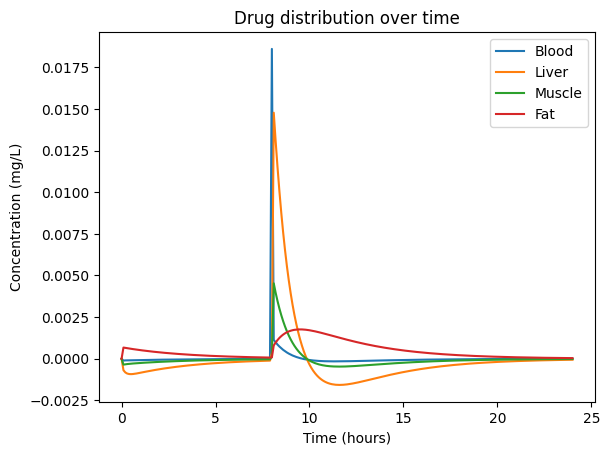

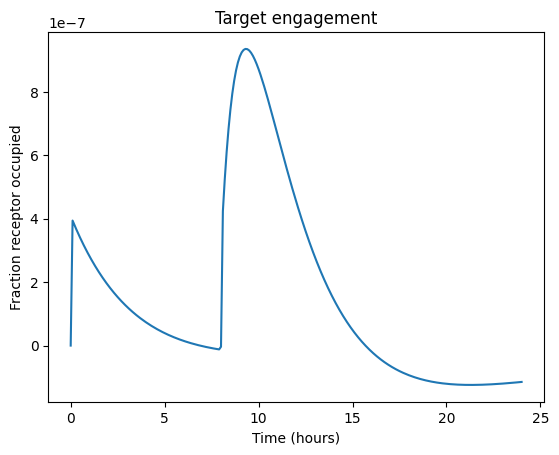

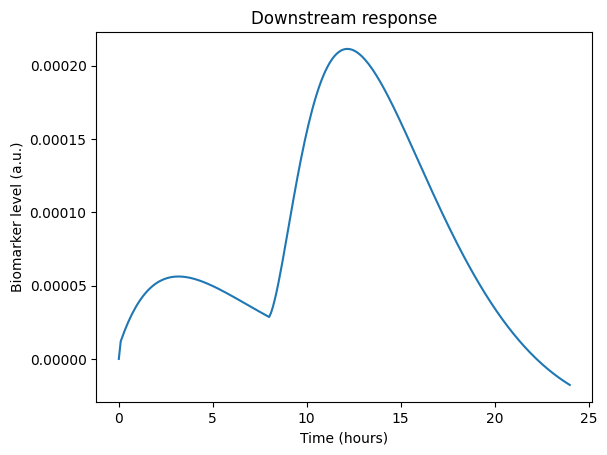

In [ ]:
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from dataclasses import dataclass

# --- 1) Data classes ---

@dataclass
class Physiology:
    """Physiological parameters for a human digital twin."""
    V_blood: float = 5.0       # L
    V_liver: float = 1.8       # L
    V_muscle: float = 29.0     # L
    V_fat: float = 18.0        # L
    CLint_liver: float = 20.0  # L/h

@dataclass
class Compound:
    """Compound‑specific PBPK properties."""
    Kp_liver: float = 10.0
    Kp_muscle: float = 3.0
    Kp_fat: float = 50.0
    k_abs: float = 1.0         # 1/h gut absorption

@dataclass
class DosingEvent:
    """Defines a dose event: 'iv_bolus' or 'oral'."""
    type: str      # 'iv_bolus' or 'oral'
    amount: float  # mg
    time: float    # h

# --- 2) Simulator class ---

class PBPKQSPSimulator:
    def __init__(self, phys: Physiology, cmpd: Compound, qsp_params):
        self.phys = phys
        self.cmpd = cmpd
        # QSP params = (kon, koff, Rtot, kprod, kdeg)
        self.kon, self.koff, self.Rtot, self.kprod, self.kdeg = qsp_params

    def odes(self, t, y, events):
        # y = [Agut, Ab, Aliv, Amusc, Afat, Rf, Rc, M]
        Agut, Ab, Aliv, Amusc, Afat, Rf, Rc, M = y

        # apply dosing
        for ev in events:
            if ev.type=='iv_bolus' and abs(t-ev.time)<1e-3:
                Ab += ev.amount
            elif ev.type=='oral' and abs(t-ev.time)<1e-3:
                Agut += ev.amount

        # gut absorption
        dAgut = -self.cmpd.k_abs * Agut
        dAb   =  self.cmpd.k_abs * Agut

        # concentrations
        Cb   = Ab   / self.phys.V_blood
        Cliv = Aliv / self.phys.V_liver
        Cm   = Amusc/ self.phys.V_muscle
        Cf   = Afat / self.phys.V_fat

        # blood flows (L/h)
        Ql, Qm, Qf = 90.0, 450.0, 30.0

        # distribution fluxes
        f_liv  = Ql*(Cb - Cliv/self.cmpd.Kp_liver)
        f_musc = Qm*(Cb - Cm  /self.cmpd.Kp_muscle)
        f_fat  = Qf*(Cb - Cf  /self.cmpd.Kp_fat)

        dAb   += -f_liv - f_musc - f_fat
        dAliv =  f_liv
        dAmusc=  f_musc
        dAfat =  f_fat

        # QSP: receptor binding & biomarker
        bind = self.kon*Cb*Rf - self.koff*Rc
        dRf = -bind
        dRc =  bind
        dM  = self.kprod*Rc - self.kdeg*M

        return [dAgut, dAb, dAliv, dAmusc, dAfat, dRf, dRc, dM]

    def simulate(self, events, t_end=24.0, dt=0.1):
        # initial state: no drug in compartments, all receptor free, no complex/biomarker
        y0 = [0.0,0.0,0.0,0.0,0.0,self.Rtot,0.0,0.0]
        t_eval = np.arange(0, t_end+dt, dt)

        sol = solve_ivp(
            lambda t,y: self.odes(t,y,events),
            [0, t_end], y0, t_eval=t_eval, method='RK45'
        )

        cols = ['Gut','Blood','Liver','Muscle','Fat','Free_Receptor','Complex','Biomarker']
        df = pd.DataFrame(sol.y.T, columns=cols)
        df.insert(0, 'Time_h', sol.t)
        return df

# --- 3) Main: run and visualize ---

if __name__ == "__main__":
    phys   = Physiology()
    cmpd   = Compound()
    qsp    = (1e-3, 0.1, 100.0, 1.0, 0.2)
    events = [ DosingEvent('iv_bolus',  50.0, time=0.0),
               DosingEvent('oral',     100.0, time=8.0) ]

    sim = PBPKQSPSimulator(phys, cmpd, qsp)
    df  = sim.simulate(events)

    # compute tissue concentrations
    df['Blood_conc']  = df['Blood']/phys.V_blood
    df['Liver_conc']  = df['Liver']/phys.V_liver
    df['Muscle_conc'] = df['Muscle']/phys.V_muscle
    df['Fat_conc']    = df['Fat']/phys.V_fat

    # Plot: drug in organs
    plt.figure()
    for organ in ['Blood','Liver','Muscle','Fat']:
        plt.plot(df['Time_h'], df[f'{organ}_conc'], label=organ)
    plt.xlabel('Time (hours)')
    plt.ylabel('Concentration (mg/L)')
    plt.title('Drug distribution over time')
    plt.legend()
    plt.show()

    # Plot: receptor occupancy
    plt.figure()
    occupancy = df['Complex']/qsp[2]
    plt.plot(df['Time_h'], occupancy)
    plt.xlabel('Time (hours)')
    plt.ylabel('Fraction receptor occupied')
    plt.title('Target engagement')
    plt.show()

    # Plot: biomarker response
    plt.figure()
    plt.plot(df['Time_h'], df['Biomarker'])
    plt.xlabel('Time (hours)')
    plt.ylabel('Biomarker level (a.u.)')
    plt.title('Downstream response')
    plt.show()
